In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

from PIL import Image
from pose_vector_to_transformation_matrix import \
    pose_vector_to_transformation_matrix
from project_points import project_points
from undistort_image import undistort_image
from undistort_image_vectorized import undistort_image_vectorized

In [2]:
# load camera poses

# each row i of matrix 'poses' contains the transformations that transforms
# points expressed in the world frame to
# points expressed in the camera frame

pose_vectors = np.loadtxt('data/poses.txt')

# load camera intrinsics
K = np.loadtxt('data/K.txt')  # calibration matrix[3x3]
D = np.loadtxt('data/D.txt')  # distortion coefficients[2x1]

# load one image with a given index
img_index = 1
img = cv2.imread('data/images/img_{0:04d}.jpg'.format(img_index))
height, width, _ = img.shape

# project the corners on the image
# compute the 4x4 homogeneous transformation matrix that maps points
# from the world to the camera coordinate frame

T_C_W = pose_vector_to_transformation_matrix(pose_vectors[img_index - 1, :])

In [3]:
# define 3D corner positions
# [Nx3] matrix containing the corners of the checkerboard as 3D points
# (X,Y,Z), expressed in the world coordinate system

square_size = 0.04  # [m]
num_corners_x = 9
num_corners_y = 6
num_corners = num_corners_x * num_corners_y

X, Y = np.meshgrid(np.arange(num_corners_x), np.arange(num_corners_y))
p_W_corners = square_size * np.stack([X, Y],
                                        axis=-1).reshape([num_corners, 2])

# add z coordinate, set z=0
p_W_corners = np.concatenate(
    [p_W_corners, np.zeros([num_corners, 1])], axis=-1)

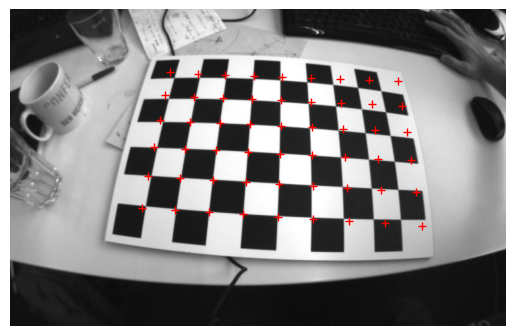

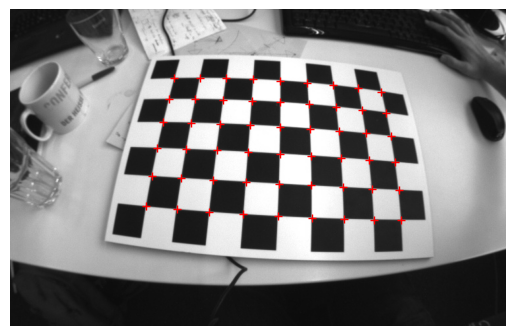

In [4]:
%matplotlib inline

# transform 3d points from world to current camera pose
p_C_corners = np.matmul(T_C_W[None, :, :],
                        np.concatenate([p_W_corners,
                                        np.ones([num_corners, 1])],
                                        axis=-1)[:, :, None]).squeeze(-1)
p_C_corners = p_C_corners[:, :3]

# projected_pts1 = project_points(p_C_corners, K, D)

projected_pts2 = project_points(p_C_corners, K, np.zeros([2, 1]))
projected_pts3 = project_points(p_C_corners, K, D)

plt.imshow(img, cmap='gray')
plt.plot(projected_pts2[:, 0], projected_pts2[:, 1], 'r+')
plt.axis('off')
plt.show()

plt.imshow(img, cmap='gray')
plt.plot(projected_pts3[:, 0], projected_pts3[:, 1], 'r+')
plt.axis('off')
plt.show()

Undistortion with bilinear interpolation completed in 5.63858962059021
Vectorized undistortion completed in 0.017235994338989258


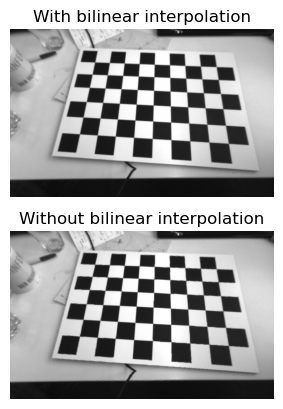

In [5]:
# undistort image with bilinear interpolation
start_t = time.time()
img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)
print('Undistortion with bilinear interpolation completed in {}'.format(
    time.time() - start_t))

# vectorized undistortion without bilinear interpolation
start_t = time.time()
img_undistorted_vectorized = undistort_image_vectorized(img, K, D)
print('Vectorized undistortion completed in {}'.format(
    time.time() - start_t))

plt.clf()
plt.close()
fig, axs = plt.subplots(2)
axs[0].imshow(img_undistorted, cmap='gray')
axs[0].set_axis_off()
axs[0].set_title('With bilinear interpolation')
axs[1].imshow(img_undistorted_vectorized, cmap='gray')
axs[1].set_axis_off()
axs[1].set_title('Without bilinear interpolation')
plt.show()


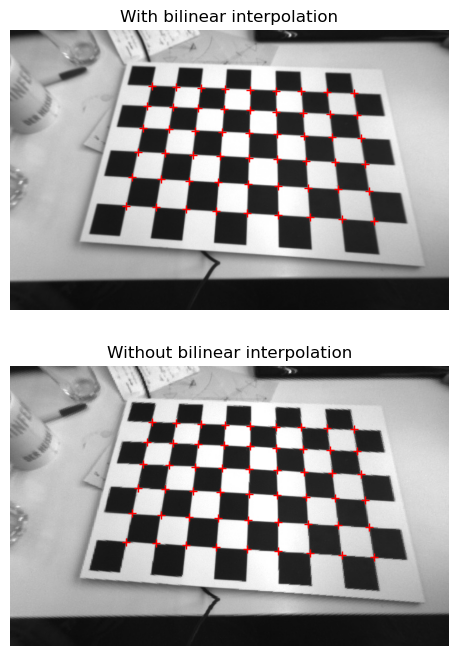

In [6]:
plt.clf()
plt.close()
fig, axs = plt.subplots(2, figsize=(20, 8)) 
axs[0].imshow(img_undistorted, cmap='gray')
axs[0].set_axis_off()
axs[0].set_title('With bilinear interpolation')
axs[0].plot(projected_pts2[:, 0], projected_pts2[:, 1], 'r+')
axs[1].imshow(img_undistorted_vectorized, cmap='gray')
axs[1].set_axis_off()
axs[1].set_title('Without bilinear interpolation')
axs[1].plot(projected_pts2[:, 0], projected_pts2[:, 1], 'r+')
plt.show()


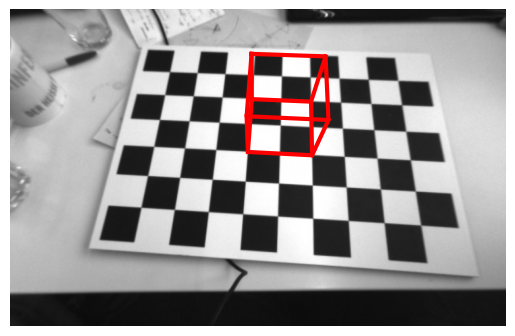

In [7]:
# calculate the cube points to then draw the image
offset_x = 0.04 * 3
offset_y = 0.04
s = 2 * 0.04

X, Y, Z = np.meshgrid(np.arange(2), np.arange(2), np.arange(-1, 1))
p_W_cube = np.stack([offset_x + X.flatten()*s,
                        offset_y + Y.flatten()*s,
                        Z.flatten()*s,
                        np.ones([8])], axis=-1)

p_C_cube = np.matmul(T_C_W[None, :, :], p_W_cube[:, :, None]).squeeze(-1)
p_C_cube = p_C_cube[:, :3]

cube_pts = project_points(p_C_cube, K, np.zeros([2, 1])) # radial distortion만 사용됨

# Plot the cube
plt.clf()
plt.close()
plt.imshow(img_undistorted, cmap='gray')

lw = 3

# base layer of the cube
plt.plot(cube_pts[[1, 3, 7, 5, 1], 0],
            cube_pts[[1, 3, 7, 5, 1], 1],
            'r-',
            linewidth=lw)

# top layer of the cube
plt.plot(cube_pts[[0, 2, 6, 4, 0], 0],
            cube_pts[[0, 2, 6, 4, 0], 1],
            'r-',
            linewidth=lw)

# vertical lines
plt.plot(cube_pts[[0, 1], 0], cube_pts[[0, 1], 1], 'r-', linewidth=lw)
plt.plot(cube_pts[[2, 3], 0], cube_pts[[2, 3], 1], 'r-', linewidth=lw)
plt.plot(cube_pts[[4, 5], 0], cube_pts[[4, 5], 1], 'r-', linewidth=lw)
plt.plot(cube_pts[[6, 7], 0], cube_pts[[6, 7], 1], 'r-', linewidth=lw)

plt.axis('off')
plt.show()

In [12]:
# Re-generate img_undistored
img_undistorted = undistort_image_vectorized(img, K, D)

In [13]:
# calculate the cube points to then draw the image
offset_x = 0.04 * 3
offset_y = 0.04
s = 2 * 0.04

X, Y, Z = np.meshgrid(np.arange(2), np.arange(2), np.arange(-1, 1))
p_W_cube = np.stack([
    offset_x + X.flatten()*s,
    offset_y + Y.flatten()*s,
    Z.flatten()*s,
    np.ones([8])], axis=-1)
p_W_cube = p_W_cube.reshape(8, 1, 4)

vertex_id = (
    0, 2, 6, 4, # base layer of the cube
    1, 3, 7, 5, # top layer of the cube
)

lines_id = (
    [0, 1], [2, 3], [4, 5], [6, 7], # vertical lines
    [0, 2], [2, 6], [6, 4], [4, 0], # base lines
    [1, 3], [3, 7], [7, 5], [5, 1], # top lines
)

# set points in world coordinate
num_pts_per_line = 50
weights = np.linspace(0, 1, num_pts_per_line)[..., None]
p_W_cube_all = np.zeros((num_pts_per_line * 12, 4))
for ii, line in enumerate(lines_id):
    indices = slice(ii * num_pts_per_line, (ii + 1) * num_pts_per_line)
    p_W_cube_all[indices] = (weights * p_W_cube[line[0]] + (1 - weights) * p_W_cube[line[1]]).reshape(-1, 4)


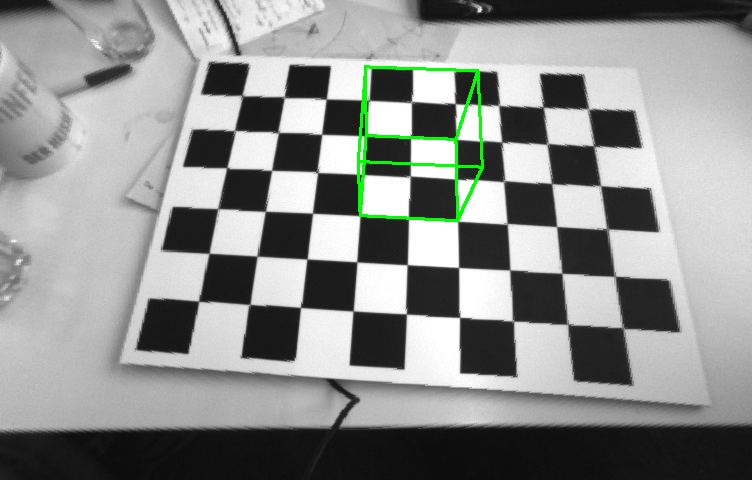

In [14]:
# project on image coordinate
p_C_cube = np.matmul(T_C_W[None, :, :], p_W_cube_all[:, :, None]).squeeze(-1)
p_C_cube = p_C_cube[:, :3]

cube_pts = project_points(p_C_cube, K, np.zeros([2, 1]))
cube_pts_int = cube_pts.astype(int) 
cube_pts_int = np.unique(cube_pts_int, axis=0)

# draw points
for x, y in cube_pts_int:
    for iy in range(-1, 2):
        for ix in range(-1, 2):
            img_undistorted[y+iy, x+ix] = (0, 255, 0)

Image.fromarray(img_undistorted)

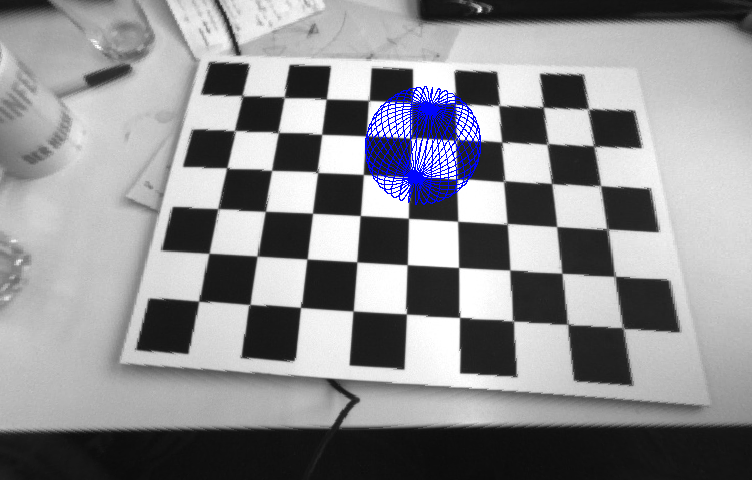

In [65]:
radius = 0.05  # Radius of the sphere
num_latitude = 200  # Number of latitude divisions
num_longitude = 40  # Number of longitude divisions

def generate_sphere_points(radius, num_latitude, num_longitude):
    latitudes = np.linspace(-np.pi / 2, np.pi / 2, num_latitude)  # Latitude angles
    longitudes = np.linspace(0, 2 * np.pi, num_longitude)  # Longitude angles

    sphere_points = []
    for lat in latitudes:
        for lon in longitudes:
            x = radius * np.cos(lat) * np.cos(lon)
            y = radius * np.cos(lat) * np.sin(lon)
            z = radius * np.sin(lat)
            sphere_points.append([x+0.17, y+0.05, z])
    return np.array(sphere_points)

sphere_points = generate_sphere_points(radius, num_latitude, num_longitude)

# Add homogeneous coordinate (for transformation)
sphere_points_homogeneous = np.hstack((sphere_points, np.ones((sphere_points.shape[0], 1))))

# Project sphere points to image plane
p_C_sphere = np.matmul(T_C_W[None, :, :], sphere_points_homogeneous[:, :, None]).squeeze(-1)
p_C_sphere = p_C_sphere[:, :3]

# Project points on the image
sphere_pts = project_points(p_C_sphere, K, np.zeros([2, 1]))
sphere_pts_int = sphere_pts.astype(int)
sphere_pts_int = np.unique(sphere_pts_int, axis=0)

# Draw sphere points on the image
img_undistorted = undistort_image_vectorized(img, K, D)
for x, y in sphere_pts_int:
    for iy in range(0, 1):
        for ix in range(0, 1):
            if 0 <= y + iy < img_undistorted.shape[0] and 0 <= x + ix < img_undistorted.shape[1]:
                img_undistorted[y + iy, x + ix] = (0, 5, 255)  # Yellow color for sphere

# Display the image
Image.fromarray(img_undistorted)


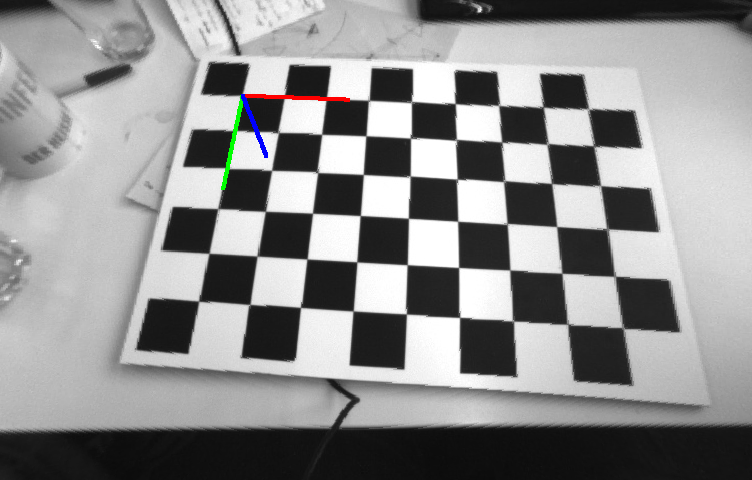

In [34]:
def draw_axis(img, start_point, end_point, T_C_W, K, color, num_pts_per_line=50):
    """
    Draw a single axis on the image.

    Args:
        img: Image array to draw on.
        start_point: Start point of the axis in world coordinates (4D homogeneous).
        end_point: End point of the axis in world coordinates (4D homogeneous).
        T_C_W: Transformation matrix from world to camera coordinates.
        K: Camera matrix.
        color: RGB color tuple (e.g., (255, 0, 0)).
        num_pts_per_line: Number of points to sample along the axis line.
    """
    # Generate intermediate points along the axis
    weights = np.linspace(0, 1, num_pts_per_line)[..., None]
    line_points = (weights * start_point + (1 - weights) * end_point).reshape(-1, 4)

    # Transform to camera coordinates
    p_C_line = np.matmul(T_C_W[None, :, :], line_points[:, :, None]).squeeze(-1)
    p_C_line = p_C_line[:, :3]

    # Project to image plane
    projected_pts = project_points(p_C_line, K, np.zeros([2, 1]))
    projected_pts_int = projected_pts.astype(int)

    # Draw on the image
    for x, y in projected_pts_int:
        for iy in range(-1, 3):
            for ix in range(-1, 3):
                if 0 <= y + iy < img.shape[0] and 0 <= x + ix < img.shape[1]:
                    img[y + iy, x + ix] = color


# Re-generate img_undistorted
img_undistorted = undistort_image_vectorized(img, K, D)

# Define XYZ coordinate system points (I shape)
origin = np.array([0, 0, 0, 1])  # 원점
x_axis_end = np.array([0.1, 0, 0, 1])  
y_axis_end = np.array([0, 0.1, 0, 1]) 
z_axis_end = np.array([0, 0, 0.1, 1]) 

# Axis colors
axis_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Red (X), Green (Y), Blue (Z)

# Draw each axis
draw_axis(img_undistorted, origin, x_axis_end, T_C_W, K, axis_colors[0])  # X-axis
draw_axis(img_undistorted, origin, y_axis_end, T_C_W, K, axis_colors[1])  # Y-axis
draw_axis(img_undistorted, origin, z_axis_end, T_C_W, K, axis_colors[2])  # Z-axis

# Display the image
Image.fromarray(img_undistorted)
